# Chest X-Ray Images for Pneumonia

## Table of Contents

1. Introduction
2. Importing Data
3. Creating plotting functions 
4. Setting up Training and Testing Data
5. Convolutional Neural Network 1
6. Convolutional Neural Network 2

### 1. Introduction

In this notebook, I will be creating two different models and evaluating their effectiveness on our data. The goal is to find the best model for predicting whether a patient has pneumonia based on a chest X-ray. 

### 2. Importing Data

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import seaborn as sns
import random

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import HyperModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

<ipython-input-1-7d1a1f0ee84a>:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
categories = ['NORMAL', 'PNEUMONIA']
datasets = ['train', 'test']

In [3]:
widths = []
heights = []

for sets in datasets:
    for cat in categories:
        filelist = glob.glob('/Users/kasey.larsen/Documents/GitHub/Chest-X-Ray-Images-Pneumonia-/chest_xray/' + 
                             sets + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: ", round(images_size["widths"].mean(), 2))
print("Average image height: ", round(images_size["heights"].mean(), 2))

Average image width:  1327.83
Average image height:  970.6


In [4]:
im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " , str(im_width))
print("image height: " , str(im_height))

image width:  132
image height:  97


### 3. Creating plotting functions 

In [5]:
# This function will plot the confusion matrix in a heat map for each model

def plot_confusion(con_mat):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Model Accuracy')
    plt.show()

In [6]:
# This function will plot the images with their predicted labels and true labels

def plot_model_images_acc():
    
    cor = []
    for i in range(len(y_pred)):
        pred = categories[int(np.round(y_pred)[i][0])]
        actual = categories[y_test[i]]
        if pred == actual:
            cor.append(i)
    cor = cor[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Accurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        image = X_test[cor[j]]
        pred = categories[int(np.round(y_pred)[cor[j]][0])]
        actual = categories[y_test[cor[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [7]:
def plot_model_images_acc_pca():
    
    cor = []
    for i in range(len(y_pred)):
        pred = categories[y_pred[i]]
        actual = categories[y_test[i]]
        if pred == actual:
            cor.append(i)
    cor = cor[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Accurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        X_test_1 = X_test.reshape(1168, 97, 132, 1)
        image = X_test_1[cor[j]]
        pred = categories[y_pred[cor[j]]]
        actual = categories[y_test[cor[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [8]:
def plot_model_images_inc():

    inc = []
    for i in range(len(y_pred)):
        pred = categories[int(np.round(y_pred)[i][0])]
        actual = categories[y_test[i]]
        if pred != actual:
            inc.append(i)
    inc = inc[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Inaccurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        image = X_test[inc[j]]
        pred = categories[int(np.round(y_pred)[inc[j]][0])]
        actual = categories[y_test[inc[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [9]:
def plot_model_images_inc_pca():
    
    inc = []
    for i in range(len(y_pred)):
        pred = categories[y_pred[i]]
        actual = categories[y_test[i]]
        if pred != actual:
            inc.append(i)
    inc = inc[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Inaccurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        X_test_1 = X_test.reshape(1168, 97, 132, 1)
        image = X_test_1[inc[j]]
        pred = categories[y_pred[inc[j]]]
        actual = categories[y_test[inc[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [10]:
# This function will plot the accuracy and loss history for the model

plt.rcParams['figure.figsize'] = (12, 14)
def plot_accuracy_loss():
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='upper left')
    
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='upper left')

### 4. Setting up Training and Testing Data

In [11]:
X = []
y = []

for sets in datasets:
    for cat in categories:
        filelist = glob.glob('/Users/kasey.larsen/Documents/GitHub/Chest-X-Ray-Images-Pneumonia-/chest_xray/' + sets + '/' + cat + '/*.jpeg')
        y.extend([cat for _ in filelist])
        X.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])
# 
X_array = np.stack(X, axis=0)

In [12]:
for n, i in enumerate(y):
    if i == 'NORMAL':
        y[n] = 0
    else:
        y[n] = 1

In [13]:
y_array = np.array(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, random_state=43, test_size=0.2)

In [15]:
X_train.shape

(4672, 97, 132)

In [16]:
X_test.shape

(1168, 97, 132)

In [17]:
y_train.shape

(4672,)

In [18]:
y_test.shape

(1168,)

In [19]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

### 5a. Linear Regression 

In [20]:
pca = PCA()

In [21]:
X_train = X_train.reshape(4672, 12804)
X_test = X_test.reshape(1168, 12804)

In [22]:
X_train_transformed = pca.fit_transform(X_train)

In [26]:
X_test_transformed = pca.transform(X_test)

In [27]:
model = LogisticRegression()

parameters = {'class_weight': ['balanced', None],
              'penalty' : ['l1', 'l2', 'none'],
              'C': np.arange(0.5, 20.0, 0.5),
              'fit_intercept': [True, False],
             'multi_class': ['auto','ovr','multinomial']}

In [28]:
lg_random = RandomizedSearchCV(estimator = model, param_distributions = parameters,
                               verbose = False, n_iter = 10, cv = 5, random_state=42, n_jobs = -1)
lg_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", lg_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.85787928 0.85274399 0.85424292 0.85145805        nan        nan
 0.86429983 0.8572378  0.85145805        nan]
  warnings.warn(


 Results from Random Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=2.0, class_weight='balanced', fit_intercept=False,
                   multi_class='ovr')


/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
y_pred = lg_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

ValueError: X has 1168 features per sample; expecting 4672

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lg_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [ ]:
plot_model_images_acc_pca()

In [ ]:
plot_model_images_inc_pca()

In [ ]:
lg_acc_score = accuracy_score(y_test, y_pred)
lg_pre_score = precision_score(y_test, y_pred)
lg_rec_score = recall_score(y_test, y_pred)
lg_f1_score = f1_score(y_test, y_pred)

### 5b. Decision Tree Classifier

In [ ]:
model = DecisionTreeClassifier()

parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [3,4,5,10,15,20,25,50,75,100,125,150,200, None]}

In [ ]:
dt_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               random_state=42, n_jobs = -1)
dt_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", dt_random.best_estimator_)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(dt_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [ ]:
y_pred = dt_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

In [ ]:
plot_model_images_acc_pca()

In [ ]:
plot_model_images_inc_pca()

In [ ]:
dt_acc_score = accuracy_score(y_test, y_pred)
dt_pre_score = precision_score(y_test, y_pred)
dt_rec_score = recall_score(y_test, y_pred)
dt_f1_score = f1_score(y_test, y_pred)

### 5c. Random Forest Classifier

In [ ]:
model = RandomForestClassifier()

parameters = {'n_estimators': [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
              'criterion': ['gini', 'entropy'],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'min_weight_fraction_leaf': [0.01, 0.1, 0.25, 0.001, 0.5, 0.75, 0.9],
               'bootstrap': [True, False]}

In [ ]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
rf_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rf_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [ ]:
y_pred = rf_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

In [ ]:
plot_model_images_acc_pca()

In [ ]:
plot_model_images_inc_pca()

In [ ]:
rf_acc_score = accuracy_score(y_test, y_pred)
rf_pre_score = precision_score(y_test, y_pred)
rf_rec_score = recall_score(y_test, y_pred)
rf_f1_score = f1_score(y_test, y_pred)

### 5d. XGB Classifier

In [ ]:
model = XGBClassifier()

parameters = {'n_estimators':[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.25, 0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'class_weight':[None,'balanced'],
          'max_depth': [1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
          'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
         }

In [ ]:
xgb_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
xgb_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", xgb_random.best_estimator_)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgb_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [ ]:
y_pred = xgb_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

In [ ]:
plot_model_images_acc_pca()

In [ ]:
plot_model_images_inc_pca()

In [ ]:
xgb_acc_score = accuracy_score(y_test, y_pred)
xgb_pre_score = precision_score(y_test, y_pred)
xgb_rec_score = recall_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)

### 6a. Convolutional Neural Network 1

In [30]:
batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch

epochs = 25 # repeat 25 times

In [31]:
X_train = X_train.reshape(4672, 97, 132, 1)
X_test = X_test.reshape(1168, 97, 132, 1)

In [32]:
def base_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(im_height, im_width, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

# Train model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_1 = base_model()
cnn_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 132, 32)       320       
_________________________________________________________________
activation (Activation)      (None, 97, 132, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 32, 32)        0

In [33]:
es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = cnn_1.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/25
103/103 [==============================] - 40s 374ms/step - loss: 0.4332 - accuracy: 0.8034 - val_loss: 0.3002 - val_accuracy: 0.8873
Epoch 2/25
103/103 [==============================] - 40s 385ms/step - loss: 0.2261 - accuracy: 0.9131 - val_loss: 0.1850 - val_accuracy: 0.9322
Epoch 3/25
103/103 [==============================] - 40s 392ms/step - loss: 0.1753 - accuracy: 0.9336 - val_loss: 0.1481 - val_accuracy: 0.9401
Epoch 4/25
103/103 [==============================] - 41s 402ms/step - loss: 0.1454 - accuracy: 0.9422 - val_loss: 0.1421 - val_accuracy: 0.9444
Epoch 5/25
103/103 [==============================] - 41s 393ms/step - loss: 0.1387 - accuracy: 0.9483 - val_loss: 0.1417 - val_accuracy: 0.9451
Epoch 6/25
103/103 [==============================] - 39s 380ms/step - loss: 0.1328 - accuracy: 0.9517 - val_loss: 0.1313 - val_accuracy: 0.9465
Epoch 7/25
103/103 [==============================] - 39s 376ms/step - loss: 0.1259 - accuracy: 0.9517 - val_loss: 0.1591 - val_ac

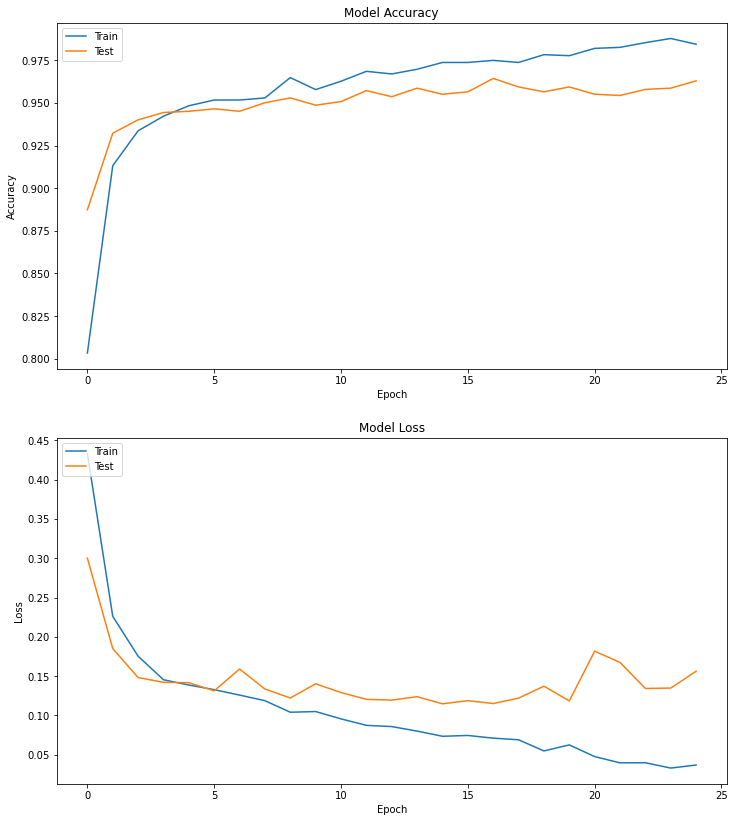

In [34]:
plot_accuracy_loss()

In [35]:
y_pred=cnn_1.predict(X_test)
y_pred_rounded = np.round(y_pred)
con_mat = confusion_matrix(y_test, y_pred_rounded)

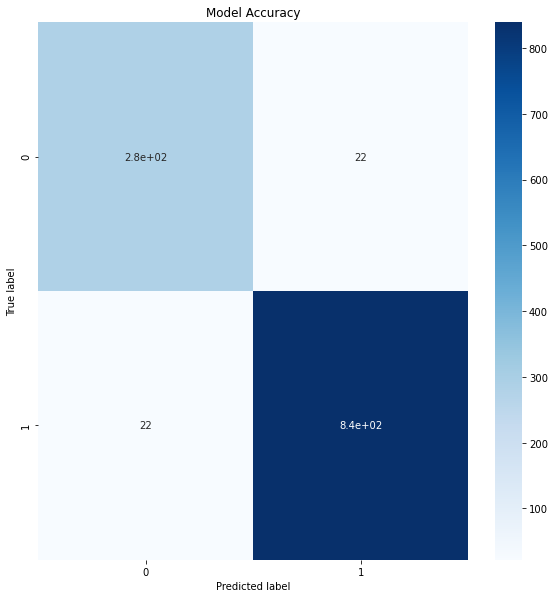

In [36]:
plot_confusion(con_mat)

In [37]:
print('Classification report: \n', classification_report(y_test, y_pred_rounded))

Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       307
           1       0.97      0.97      0.97       861

    accuracy                           0.96      1168
   macro avg       0.95      0.95      0.95      1168
weighted avg       0.96      0.96      0.96      1168



<Figure size 864x1008 with 0 Axes>

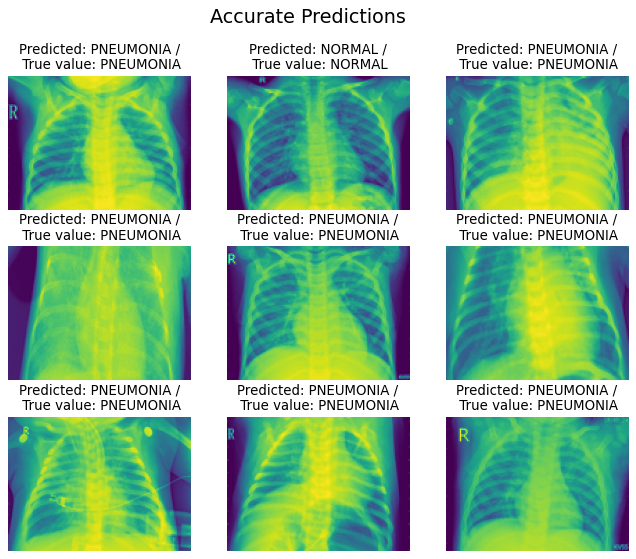

In [38]:
plot_model_images_acc()

<Figure size 864x1008 with 0 Axes>

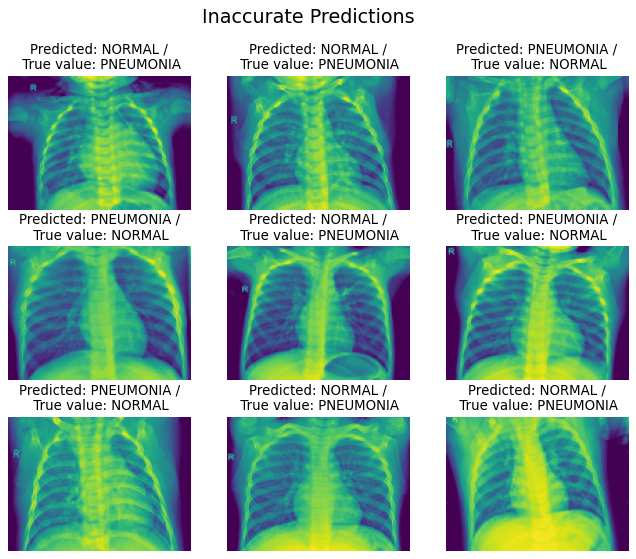

In [39]:
plot_model_images_inc()

In [40]:
cnn_1_acc_score = accuracy_score(y_test, y_pred_rounded)
cnn_1_pre_score = precision_score(y_test, y_pred_rounded)
cnn_1_rec_score = recall_score(y_test, y_pred_rounded)
cnn_1_f1_score = f1_score(y_test, y_pred_rounded)

### 6b. Convolutional Neural Network 2

In [41]:
def base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(im_height, im_width, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))


# Train model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_2 = base_model()
cnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 97, 132, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 66, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 66, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 33, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 33, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 33, 64)       

In [42]:
es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = cnn_2.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/25
103/103 [==============================] - 51s 485ms/step - loss: 0.5978 - accuracy: 0.7275 - val_loss: 0.4244 - val_accuracy: 0.7882
Epoch 2/25
103/103 [==============================] - 50s 488ms/step - loss: 0.2831 - accuracy: 0.8820 - val_loss: 0.2360 - val_accuracy: 0.8951
Epoch 3/25
103/103 [==============================] - 50s 482ms/step - loss: 0.1972 - accuracy: 0.9269 - val_loss: 0.1568 - val_accuracy: 0.9344
Epoch 4/25
103/103 [==============================] - 50s 484ms/step - loss: 0.1691 - accuracy: 0.9370 - val_loss: 0.1503 - val_accuracy: 0.9379
Epoch 5/25
103/103 [==============================] - 50s 484ms/step - loss: 0.1538 - accuracy: 0.9450 - val_loss: 0.1504 - val_accuracy: 0.9351
Epoch 6/25
103/103 [==============================] - 50s 486ms/step - loss: 0.1499 - accuracy: 0.9404 - val_loss: 0.1376 - val_accuracy: 0.9451
Epoch 7/25
103/103 [==============================] - 49s 481ms/step - loss: 0.1286 - accuracy: 0.9520 - val_loss: 0.1331 - val_ac

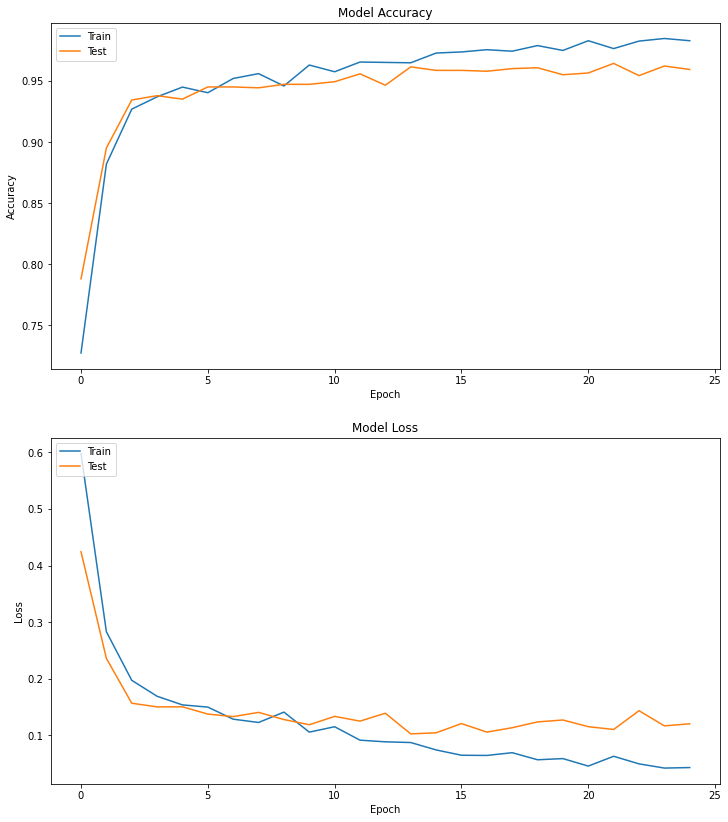

In [43]:
plot_accuracy_loss()

In [44]:
y_pred=cnn_2.predict(X_test)
y_pred_rounded = np.round(y_pred)
con_mat = confusion_matrix(y_test, y_pred_rounded)

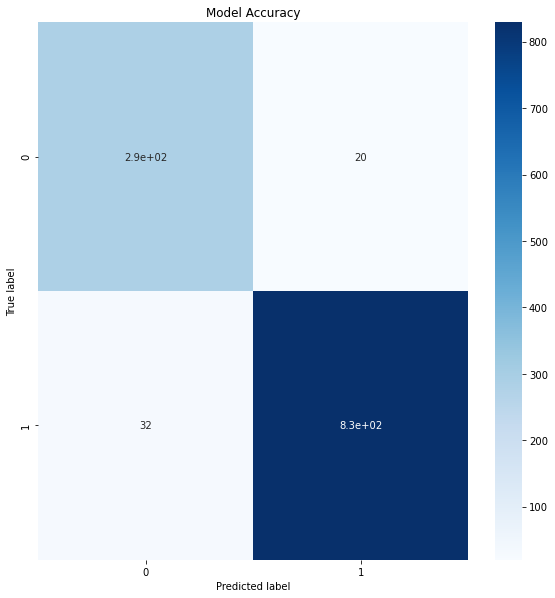

In [45]:
plot_confusion(con_mat)

In [46]:
print('Classification report: \n', classification_report(y_test, y_pred_rounded))

Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       307
           1       0.98      0.96      0.97       861

    accuracy                           0.96      1168
   macro avg       0.94      0.95      0.94      1168
weighted avg       0.96      0.96      0.96      1168



<Figure size 864x1008 with 0 Axes>

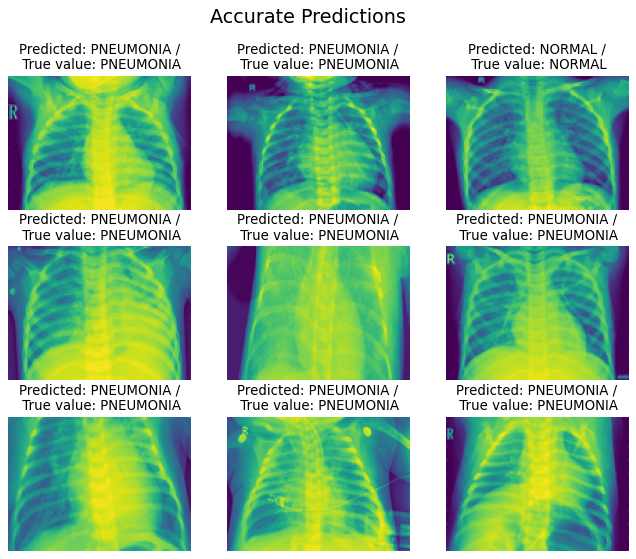

In [47]:
plot_model_images_acc()

<Figure size 864x1008 with 0 Axes>

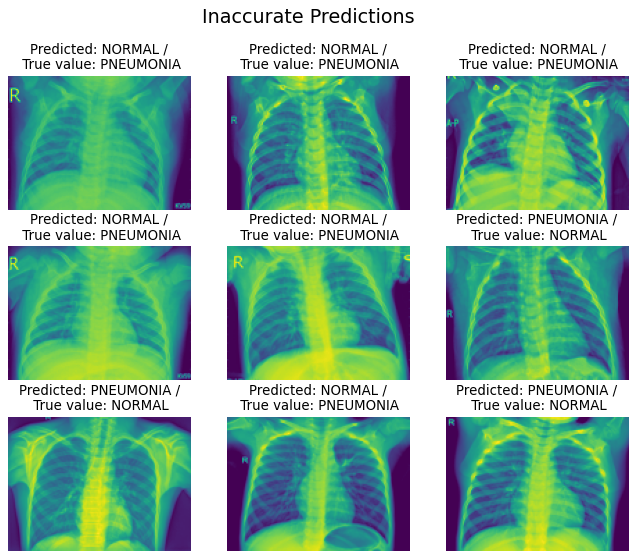

In [48]:
plot_model_images_inc()

In [49]:
cnn_2_acc_score = accuracy_score(y_test, y_pred_rounded)
cnn_2_pre_score = precision_score(y_test, y_pred_rounded)
cnn_2_rec_score = recall_score(y_test, y_pred_rounded)
cnn_2_f1_score = f1_score(y_test, y_pred_rounded)

### 6c. Hyperparameter Tuned Convolutional Neural Network

In [50]:
class CNNHyperModel(HyperModel):
  #def __init__(self, input_shape, num_classes):
    #self.input_shape =input_shape
    #self.num_classes =num_classes

    def build(self,hp):
        model=Sequential()
        model.add(Conv2D(filters=hp.Int('1Conv_num_classes',default=32,min_value=32,step=16,
                                        max_value=256),
                      activation="relu",padding='same', kernel_size=(3,3),input_shape=(im_height, im_width, 1)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=hp.Int("2Conv_num_classes",default=32,min_value=32,
                                      max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float("1Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Conv2D(filters=hp.Int("3Conv_num_classes",default=64,min_value=32,
                                       max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=hp.Int("4Conv_num_classes",default=64,min_value=32,
                            max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float("2Dropout", min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Conv2D(filters=hp.Int("5Conv_num_classes",default=128,min_value=32,
                                       max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=hp.Int("6Conv_NUM_CLASSES",default=128,min_value=32,
                                       max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float("3Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int("Dense",min_value=32,default=516,
                                 max_value=512,step=16),activation='relu'))
        model.add(Dropout(rate=hp.Float("Dense_Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Dense(units=hp.Int("2Dense",min_value=32,default=516,
                                 max_value=512,step=16),activation='relu'))
        model.add(Dropout(rate=hp.Float("2Dense_Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Dense(1,activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
        return model
#hypermodel=CNNHyperModel((28,28,1),10)    
hypermodel=CNNHyperModel()

In [51]:
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Pneumonia Classification')

INFO:tensorflow:Reloading Oracle from existing project project/Pneumonia Classification/oracle.json
INFO:tensorflow:Reloading Tuner from project/Pneumonia Classification/tuner0.json


In [52]:
tuner.search_space_summary()

Search space summary
Default search space size: 13
1Conv_num_classes (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
2Conv_num_classes (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
1Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
3Conv_num_classes (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
4Conv_num_classes (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
2Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
5Conv_num_classes (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
6Conv_NUM_CLASSES (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256,

In [53]:
tuner.search(X_train, y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
            validation_split=0.3)

Trial 3 Complete [01h 49m 06s]
val_accuracy: 0.9595815340677897

Best val_accuracy So Far: 0.9595815340677897
Total elapsed time: 01h 49m 06s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
1Conv_num_classes |112               |96                
2Conv_num_classes |48                |64                
1Dropout          |0.25              |0                 
3Conv_num_classes |32                |144               
4Conv_num_classes |144               |32                
2Dropout          |0                 |0.35              
5Conv_num_classes |80                |144               
6Conv_NUM_CLASSES |48                |48                
3Dropout          |0.15              |0.1               
Dense             |272               |144               
Dense_Dropout     |0.3               |0.1               
2Dense            |48                |160               
2Dense_Dropout    |0.25              |0.05              

Epoch 1/25
103/103 [============

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

In [ ]:
plot_accuracy_loss()

In [ ]:
y_pred=best_model.predict(X_test)
y_pred_rounded = np.round(y_pred)
con_mat = confusion_matrix(y_test, y_pred_rounded)

In [ ]:
plot_confusion(con_mat)

In [ ]:
print('Classification report: \n', classification_report(y_test, y_pred_rounded))

In [ ]:
plot_model_images_acc()

In [ ]:
plot_model_images_inc()

In [ ]:
cnn_hyp_acc_score = accuracy_score(y_test, y_pred_rounded)
cnn_hyp_pre_score = precision_score(y_test, y_pred_rounded)
cnn_hyp_rec_score = recall_score(y_test, y_pred_rounded)
cnn_hyp_f1_score = f1_score(y_test, y_pred_rounded)

### 7. Model Selection

In [ ]:
# Creating a models table
model_selection=pd.DataFrame({'Model':['Logistic Regession', 'Decision Tree Classifier', 'Random Forest Classifier',
                                        'XGBClassifier', 'Convolutional Neural Network 1',
                                      'Convolutional Neural Network 2', 'Hyperparameter Tuned Convolutional Neural Network'], 
                             'Accuracy Score':[lg_acc_score, dt_acc_score, rf_acc_score, xgb_acc_score, cnn_1_acc_score, cnn_2_acc_score, cnn_hyp_acc_score],
                             'Precision Score':[lg_pre_score, dt_pre_score, rf_pre_score, xgb_pre_score, cnn_1_pre_score, cnn_2_pre_score, cnn_hyp_pre_score],
                             'Recall Score':[lg_rec_score, dt_rec_score, rf_rec_score, xgb_rec_score, cnn_1_rec_score, cnn_2_rec_score, cnn_hyp_rec_score],
                             'F1 Score':[lg_f1_score, dt_f1_score, rf_f1_score, xgb_f1_score, cnn_1_f1_score, cnn_2_f1_score, cnn_hyp_f1_score]})

In [ ]:
model_selection

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Conv2D(filters=hp.Int('conv_1_filter',min_value=32,max_value=128,step=16),
                                                  kernel_size=hp.Choice('conv_1_kernel',values = [3,5]),
                                                  activation='relu',
                                                  input_shape=(im_height, im_width, 1)
                                                  ))
    model.add(layers.Conv2D(filters=hp.Int('conv_2_filter',min_value=32,max_value=128,step=16),
                                                  kernel_size=hp.Choice('conv_2_kernel',values = [3,5]),
                                                  activation='relu'))
    model.add(layers.Flatten())
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=1024,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model